# Stohastic gradient descent and linear models

Сгенерируем обучающую выборку в виде двух облачков точек (красное и синее). Для этого воспользуемся библиотекой numpy, которая позволяет быстро и удобно работать с матрицами. Наши облачка буду распределены нормально и иметь разные центры.

In [1]:
import numpy as np

mu_red = np.array([-1, -1])
mu_blue = np.array([1, 1])

Для генерации воспользуемся уже готовой функцией [multivariate_normal](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multivariate_normal.html). Заметим, что также нам нужно указать матрицу ковариации для каждого облака. Пусть одно из них будет побольше.

In [2]:
POINT_N = 1000

V_red = np.array([[1., 0.],[0., 1.]])
V_blue = np.array([[1., 0.],[-2., 1.]])

X_red = np.random.multivariate_normal(mu_red, V_red, POINT_N)
X_blue = np.random.multivariate_normal(mu_blue, V_blue, POINT_N)

Для отрисовки мы воспользуемся популярной библиотекой matplotlib. Нам понадобится функция [scatter](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter).

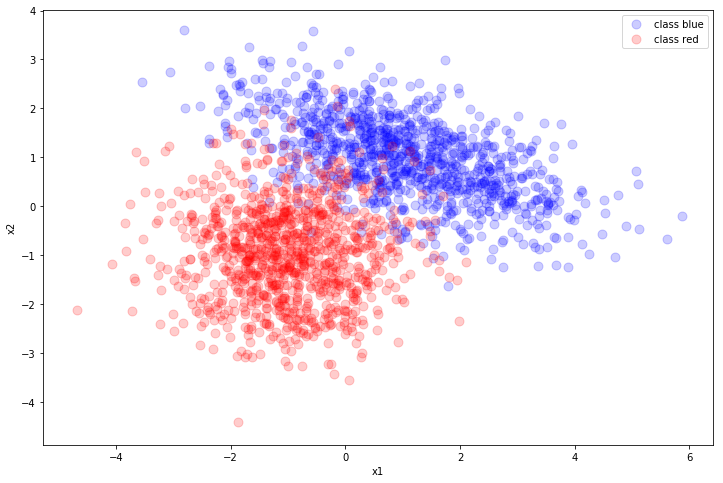

In [55]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(12, 8))
plt.xlabel('x1')
plt.ylabel('x2')

plt.scatter(
    x = X_blue[:, 0],
    y = X_blue[:, 1],
    label = 'class blue',
    color = 'blue',
    s = 80,
    alpha = 0.2
)

plt.scatter(
    x = X_red[:, 0],
    y = X_red[:, 1],
    label = 'class red',
    color = 'red',
    s = 80,
    alpha = 0.2
)

plt.legend();

Напомним, что следующая задача имеет аналитическое решение
$$\arg\min_{w}||Xw - Y ||_{2},$$
которое выглядит, как
$$w = (X^TX)^{-1}X^TY.$$
Чтобы воспользоваться этим фактом нам нужно получить вектор меток (это сделать не очень сложно). А также понять, как обучить параметр $b$, ведь наша модель выглядит
$$y = sgn(wx + b).$$
Как говорилось на занятии, для этого лишь достаточно добавить специальный единичный признак в матрицу $X$. Коэффициент $w_3$, который будет относиться к нему, по сути, и будет являться $b$. На практике, этот признак обучается отдельно, но для удобства мы сделаем именно так.

In [4]:
y_red = np.ones((POINT_N, 1))
y_blue = -np.ones((POINT_N, 1))

X = np.vstack([X_red, X_blue])
X = np.hstack([X, np.ones((2 * POINT_N, 1))])
y = np.vstack([y_red, y_blue])

Давайте напечатаем что у нас примерно вышло.

In [5]:
print('X:\n', X)
print('y:\n', y)

X:
 [[-1.24359817 -0.85494599  1.        ]
 [-1.33239998 -2.41801579  1.        ]
 [-0.34543757 -1.65049634  1.        ]
 ..., 
 [-0.28912175  1.75644197  1.        ]
 [ 0.28697382 -0.37362408  1.        ]
 [ 2.78293068  0.20612834  1.        ]]
y:
 [[ 1.]
 [ 1.]
 [ 1.]
 ..., 
 [-1.]
 [-1.]
 [-1.]]


Чтобы выборка была больше похожа на 'реальную', немного перемешаем строки в матрицах (воспользуемся функцией [shuffle](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.shuffle.html#numpy.random.shuffle)). А после этого вычислим наш вектор параметров.

In [6]:
height, _ = X.shape

permutation = np.random.permutation(height)
X = X[permutation, :]
y = y[permutation]

w_analytical = np.linalg.inv(X.T @ X) @ X.T  @ y

Напишем функцию, которая для $x1$ вычисляет $x2$ лежащий на прямой.

In [7]:
def line_x2(w, line_x1):
    return np.array(
        [-(w[0]*x1 + w[2])/w[1] for x1 in line_x1]
    )

Теперь снова отобразим оба облачка и отрисуем разделяющую прямую.

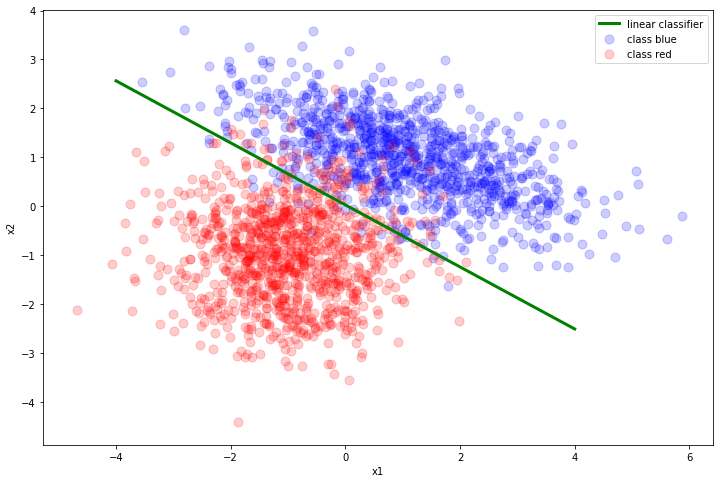

In [56]:
plt.figure(figsize=(12, 8))
plt.xlabel('x1')
plt.ylabel('x2')

plt.scatter(
    x = X_blue[:, 0],
    y = X_blue[:, 1],
    label = 'class blue',
    color = 'blue',
    s = 80,
    alpha = 0.2
)

plt.scatter(
    x = X_red[:, 0],
    y = X_red[:, 1],
    label = 'class red',
    color = 'red',
    s = 80,
    alpha = 0.2
)

line_x1 = np.array([-4., 4.])

plt.plot(
    line_x1,
    line_x2(w_analytical, line_x1),
    label = 'linear classifier',
    color = 'green',
    linewidth = 3
)

plt.legend();

Вообще говоря, функционалы качества бывают [разные](https://en.wikipedia.org/wiki/Loss_functions_for_classification#Square_loss), рассмотрим разные примеры в завимости от M (margin):

* Функция потерь для SVM [hinge loss](https://en.wikipedia.org/wiki/Hinge_loss) $\mathcal{L}(M) = \max(0, 1 - M)$
* Логистическая функция потерь [logistic loss](https://en.wikipedia.org/wiki/Loss_functions_for_classification#Logistic_loss) $\ln(1 + \exp(-M))$
* Квадратичная функция [square loss](https://en.wikipedia.org/wiki/Loss_functions_for_classification#Square_loss) $(M - 1)^2$

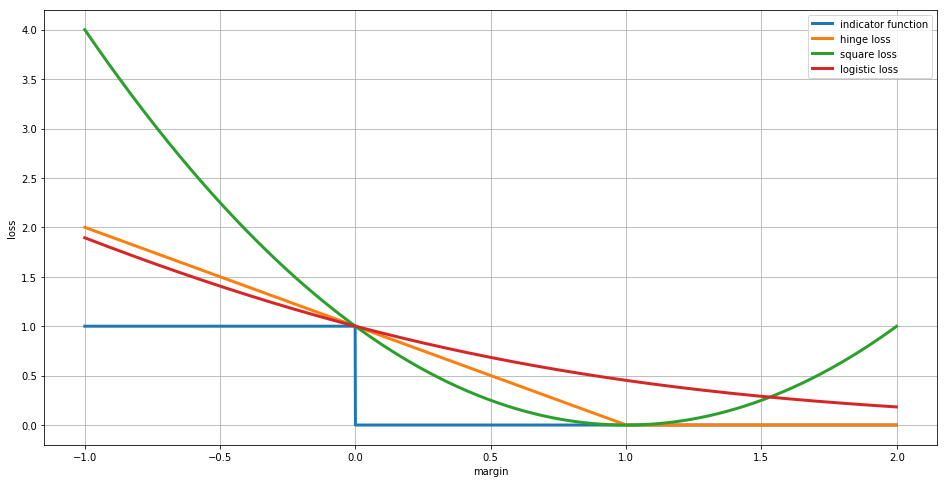

In [9]:
def hinge_loss(M):
    return np.maximum(1 - M, 0)

def square_loss(M):
    return (M - 1)**2

def logistic_loss(M):
    return np.log(1 + np.exp(-M)) / np.log(2) # normalized version

def indicator(M):
    return M <= 0

M = np.arange(-1, 2, 1e-3)

plt.figure(figsize=(16, 8))
plt.xlabel('margin')
plt.ylabel('loss')

plt.plot(M, indicator(M), label='indicator function', linewidth=3)
plt.plot(M, hinge_loss(M), label='hinge loss', linewidth=3)
plt.plot(M, square_loss(M), label='square loss', linewidth=3)
plt.plot(M, logistic_loss(M), label='logistic loss', linewidth=3)

plt.grid()
plt.legend();

Теперь плавно перейдем к обучению с помощью градиентного спуска. Определим какую-нибудь простую выпуклую квадратичную функцию

$$ Q(x, y) = x^2 - x y + 2y^2$$

И сразу вычислим ее градиент

$$\triangledown Q(x) = \Big[ 2x - y, 4y - x \Big].$$

In [10]:
def Q(x, y):
    return x**2 - x*y + 2*y**2

def Qgrad(x, y):
    return 2*x - y, 4*y - x

Также добавим два [декоратора](https://habrahabr.ru/post/141411/), которые нам пригодятся в дальнейшем.

In [11]:
import time

def vectorize(func):
    def vfunc(x):
        return np.array(
            func(*x.tolist())
        )
    
    return vfunc

def timeit(func):
    def wrapper(*args, **kvargs):
        start = time.time()
        result = func(*args, **kvargs)
        print('time {time} s.'.format(time = time.time() - start))
        return result
    
    return wrapper

Осталось только кратко описать простейшую версию [градиентного спуска](https://en.wikipedia.org/wiki/Gradient_descent).

In [12]:
@timeit
def gradient_descent(func_grad, x_init, step=1e-2, grad_min_val=1e-6):
    x = x_init
    path = []
    
    while True:
        path.append(x.copy())    
        grad = func_grad(x)
            
        if np.linalg.norm(grad) < grad_min_val:
            return x, np.array(path)
        
        x -= step * grad

Теперь протестируем метод на нашей функции

time 0.030361175537109375 s.


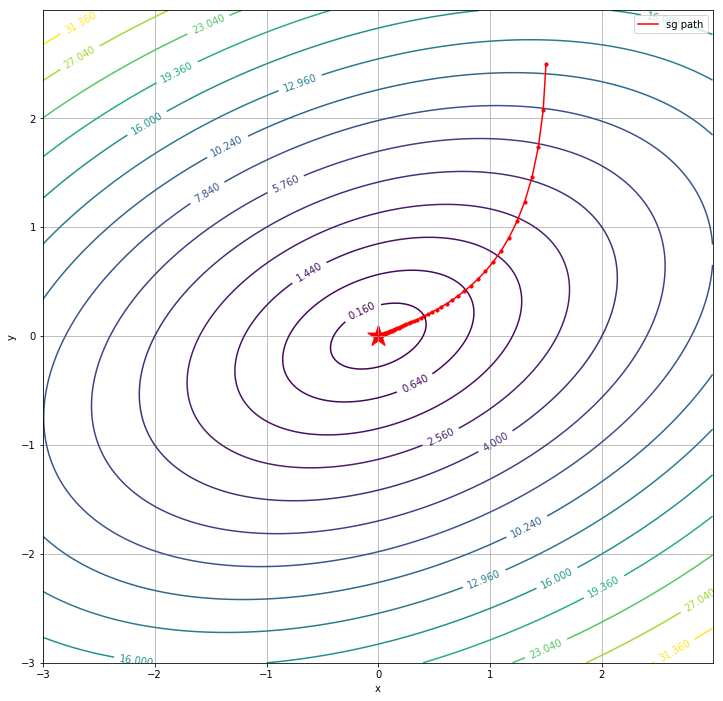

In [19]:
x_min, path = gradient_descent(vectorize(Qgrad), np.array([1.5, 2.5]), step=5e-2)

plt.figure(figsize=(12, 12))
plt.xlabel('x')
plt.ylabel('y')

x_grid, y_grid = np.meshgrid(
    np.arange(-3.0, 3.0, 0.01),
    np.arange(-3.0, 3.0, 0.01)
)

z_grid = Q(x_grid, y_grid)

levels = np.arange(0.0, 6.0, 0.4)**2
contour = plt.contour(x_grid, y_grid, z_grid, levels)
plt.clabel(contour, inline=True, fontsize=10)

plt.scatter(path[:, 0], path[:, 1], s=10, color = 'red',  marker='o')
plt.plot(path[:, 0], path[:, 1], color = 'red', label='sg path')
plt.scatter(x_min[0], x_min[1], s=500, color='red', marker='*')

plt.grid()
plt.legend();

Теперь поиграемся с функцией Розенброка

$$R(x,y)=(1−x)^2+100(y−x^2)^2$$

Очевидно, нам понадобится и ее градиент!

$$\triangledown R(x) = \Big[ 400x(x^2 - y) - 2x + 2, ~ 200(y-x^2) \Big ].$$

In [20]:
def R(x, y):
    return (1 - x)**2 + 100*(y - x**2)**2

def Rgrad(x, y):
    return 400*x*(x**2 - y) + 2*x - 2, 200*(y - x**2)

Сначала отобразим функцию Розенброка в окрестности ее минимума.

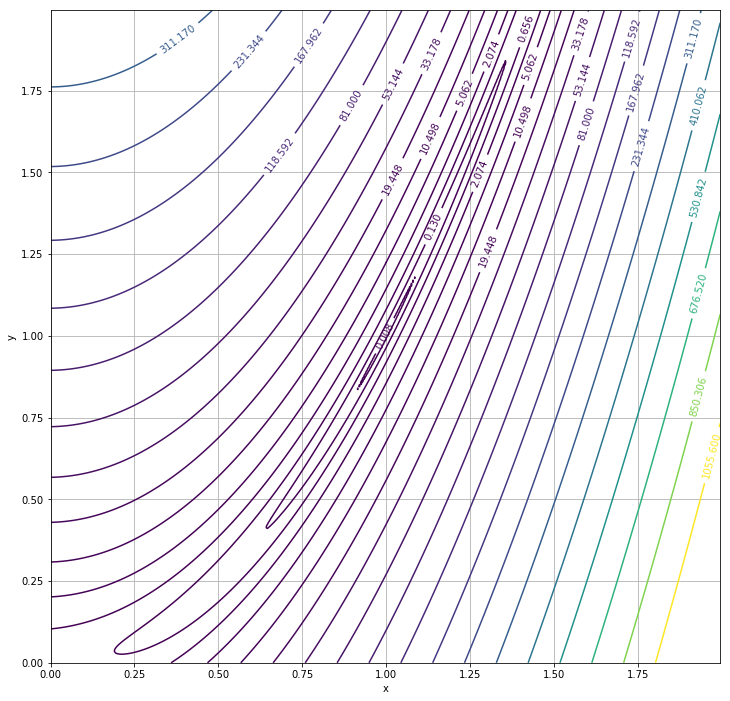

In [21]:
plt.figure(figsize=(12, 12))
plt.xlabel('x')
plt.ylabel('y')

x_grid, y_grid = np.meshgrid(
    np.arange(0.0, 2.0, 0.005),
    np.arange(0.0, 2.0, 0.005)
)

z_grid = R(x_grid, y_grid)

levels = np.arange(0.0, 6.0, 0.3)**4
contour = plt.contour(x_grid, y_grid, z_grid, levels)
plt.clabel(contour, inline=True, fontsize=10)

plt.grid()

Проблема этой функции в том, что во время градиентного спуска мы можем попасть в 'овраг', где значение градиента мало, поэтому метод будет очень медленно сходиться. Поэтому мы несколько модифицируем его. Градиент можно воспринимать только лишь, как направление движение. А шаг задавать самостоятельно.

In [22]:
@timeit
def normalized_gradient_descent(func_grad, x_init, step=1e-3, grad_min_val=1e-6, max_iter_n = 1e6):
    x = x_init
    path = []

    while True:
        path.append(x.copy())    
        grad = func_grad(x)
        grad_norm = np.linalg.norm(grad)
            
        if grad_norm < grad_min_val or len(path) >= max_iter_n:
            return x, np.array(path)
        
        step_value = step if not callable(step) else step(len(path))
        x -=  step_value * (grad / grad_norm)

Так как метод достаточно примитивный и нет гарантии сходимости, то добавим дополнительное условие остановки по максимальному количеству итераций. А еще мы теперь умеем применять шаг не в виде скаляра, а в виде лямбды.

time 8.701282024383545 s.


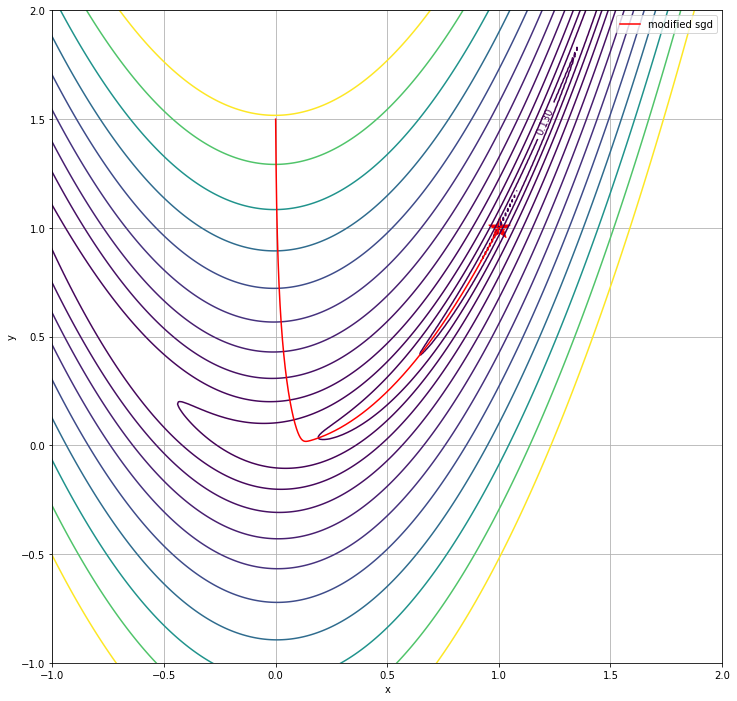

In [23]:
x_min, path = normalized_gradient_descent(
    vectorize(Rgrad),
    np.array([0.0, 1.5]),
    step = lambda t: 1e-2 / t**0.5,
    grad_min_val = 1e-2
)

plt.figure(figsize=(12, 12))
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-1, 2)
plt.ylim(-1, 2)

x_grid, y_grid = np.meshgrid(
    np.arange(-3.0, 3.0, 0.01),
    np.arange(-3.0, 3.0, 0.01)
)

z_grid = R(x_grid, y_grid)

levels = np.arange(0, 4, 0.3)**4
contour = plt.contour(x_grid, y_grid, z_grid, levels)
plt.clabel(contour, inline=True, fontsize=10)

plt.plot(path[:, 0], path[:, 1], color='red', label='modified sgd')
plt.scatter(x_min[0], x_min[1], s=500, color='red', marker='*')

plt.grid()
plt.legend();

Теперь попробуе применить наши навыки оптимизации уже для задачи машинного обучения. Мы имеем следующую функцию для оптимизации.
$$Q(w) = \frac{1}{l} \sum_{x, y} (wx - y)^2$$
Тогда частная производная по $w^j$ будет выглядеть следующим образом
$$\frac{\partial Q}{\partial w^j} = \frac{2}{l} \sum_{x, y} (wx - y) \cdot x^j$$
Обратите внимание, что в коде мы будем использовать матричную запись.

In [24]:
def Q(X, y, w):
    error = X @ w - y
    size = len(y)
    return (error * error).sum() / size 

def Qgrad(X, y, w):
    size = len(y)
    return 2 * X.T @ (X @ w - y) / size

И теперь вычислим вектор параметров. Я намеренно взял достаточно большую ошибку, чтобы прямые друг друга не перекрывали, в действительности можно сделать так, чтобы решения почти не отличались.

In [25]:
w_gradient, path_gradient = gradient_descent(
    lambda w: Qgrad(X, y, w), 
    np.zeros((3, 1)),
    grad_min_val = 3e-2
)

time 0.03101325035095215 s.


А теперь все это отрисуем.

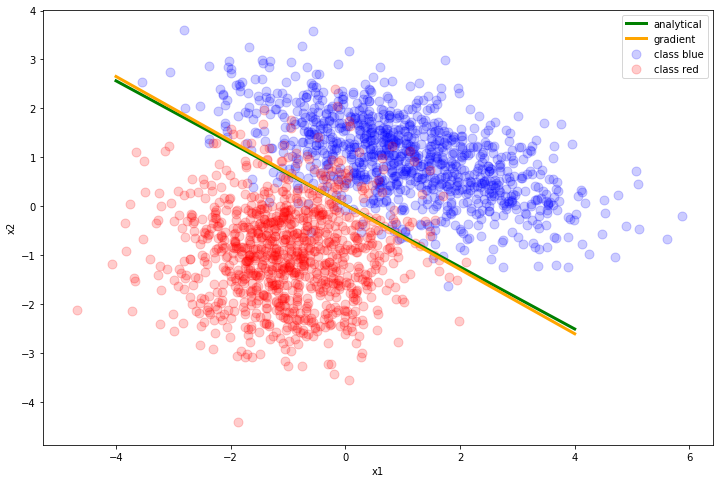

In [57]:
plt.figure(figsize=(12, 8))
plt.xlabel('x1')
plt.ylabel('x2')

plt.scatter(
    x = X_blue[:, 0],
    y = X_blue[:, 1],
    label = 'class blue',
    color = 'blue',
    s = 80,
    alpha = 0.2
)

plt.scatter(
    x = X_red[:, 0],
    y = X_red[:, 1],
    label = 'class red',
    color = 'red',
    s = 80,
    alpha = 0.2
)

line_x1 = np.array([-4., 4.])

plt.plot(
    line_x1,
    line_x2(w_analytical, line_x1),
    label = 'analytical',
    color = 'green',
    linewidth = 3
)

plt.plot(
    line_x1,
    line_x2(w_gradient, line_x1),
    label = 'gradient',
    color = 'orange',
    linewidth = 3
)

plt.legend();

Немного модифицируем нашу версию градиентного спуска, чтобы получить метод наискорейшего спуска.

In [27]:
@timeit
def fast_gradient_descent(func_grad, x_init, step, grad_min_val=1e-6):
    x = x_init
    path = []
    
    while True:
        path.append(x.copy())    
        grad = func_grad(x)
            
        if np.linalg.norm(grad) < grad_min_val:
            return x, np.array(path)
        
        x -= step(x, grad) * grad

Также необходимо определить функцию, которая будет вычислять нам оптимальный шаг. Для квадратичной функции ошибки значение находится аналитически. Нам нужно найти оптимальную $\lambda$ для следующего выражения
$$Q(w - \lambda g) = \frac{1}{\mathcal{l}}\sum_{x,y} ((w - \lambda g) \cdot x - y)^2,$$
где $g$ - текущее значение градиента.

Несложно показать, что
$$\lambda = \frac{\sum_{x,y} (wx - y) \cdot (gx)}{\sum_{x,y} \big( gx \big)^2}$$

In [28]:
def step(X, y, w, g):
    Xg = X @ g
    return (Xg.T @ (X @ w - y)) / (Xg.T @ Xg)

Теперь  запустим наш обновленный алгоритм.

In [29]:
_, path_fast_gradient = fast_gradient_descent(
    lambda w: Qgrad(X, y, w),
    np.zeros((3, 1)),
    step = lambda w, g: step(X, y, w, g),
    grad_min_val=1e-2
)

time 0.0010292530059814453 s.


Теперь посмотрим, как быстро меняется значение $Q$ от шага к шагу для обычного спуска и наискорейшего спуска.

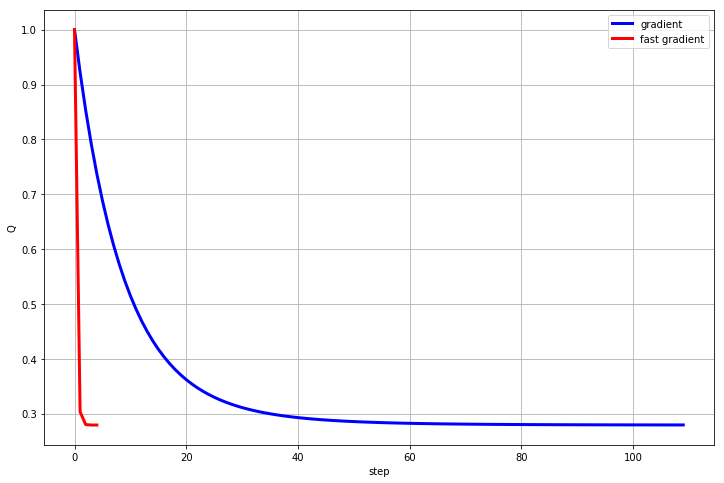

In [30]:
plt.figure(figsize=(12, 8))
plt.xlabel('step')
plt.ylabel('Q')

plt.plot(
    [Q(X, y, w) for w in path_gradient],
    label = 'gradient',
    color = 'blue',
    linewidth = 3
)

plt.plot(
    [Q(X, y, w) for w in path_fast_gradient],
    label = 'fast gradient',
    color = 'red',
    linewidth = 3
)

plt.grid()
plt.legend();

Несложно заметить, что наискорейший спуск быстрее работает, требует гораздо меньше итераций. Однако каждая итерация занимает несколько большее время, так как необходимо вычислять оптимальный шаг.

Теперь перейдем к реальным данным! Для этого нам потребуется выборка mnist. Если вы запускайте этот ноутбук, то проследите, чтобы нужный файл mnist.csv у вас был!

In [31]:
data = np.loadtxt('mnist.csv', delimiter=',', skiprows=1)

Посмотрим, как выглядит набор данных.

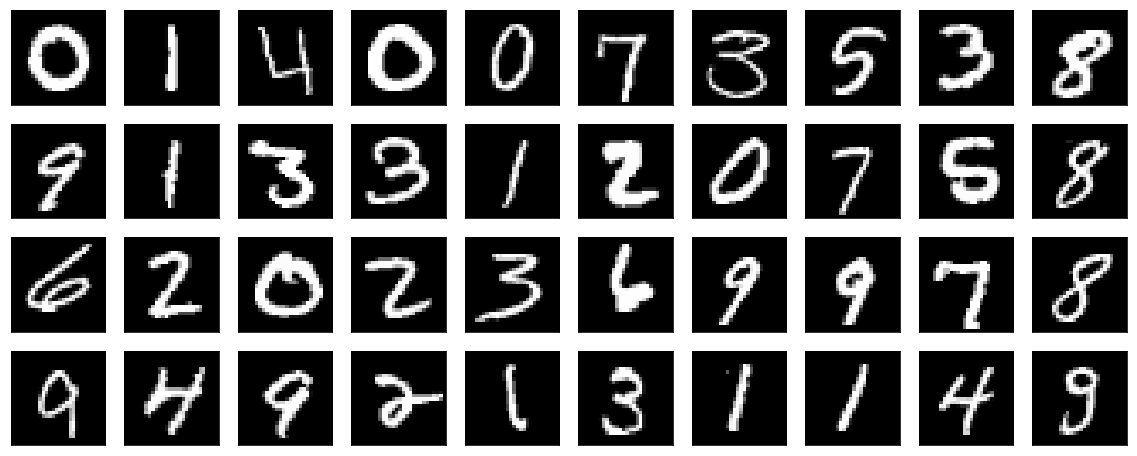

In [32]:
X, y = data[:, 1:], data[:, 0:1]

img_height, img_width = 28, 28
plot_width, plot_height = 10, 4

fig = plt.figure(figsize=(2 * plot_width, 2 * plot_height))
for sample_n in range(1, plot_width * plot_height + 1):
    ax = fig.add_subplot(plot_height, plot_width, sample_n)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(X[sample_n].reshape(img_height, img_width), cmap="gray")

Для первого этапа нам потребуются только нолики и единички! При этом единички будут соответствовать классу +1, а нолики -1.

In [33]:
index = ((y == 1) | (y == 0)).flatten()

X = X[index]
y = y[index]

y[y == 0] = -1

Теперь разделим выборку на обучающую и тестовую.

In [34]:
border = int(len(y) * 0.8)

X_train, X_test = X[:border, :], X[border:, :]
y_train, y_test = y[:border], y[border:]

Так же нам потребуется сделать специальный итератор по батчам, чтобы можно было использовать простой for и не городить огород.

In [35]:
def batch_iterator(X, y, batch_size=32):    
    begin = 0
    while begin < len(y):
        end = begin + batch_size
        yield X[begin:end, :], y[begin:end]
        begin = end

Так как необходимо использовать логистическую функцию потерь, то потребуется снова вычислять производную.

$$Q(w) = \frac{1}{\mathcal{l}} \sum_{x, y} \log(1 + \exp(-ywx))$$

$$\frac{\partial Q}{\partial w^j} = \frac{1}{l} \sum_{x, y} \frac{-y}{1 + \exp(ywx)} \cdot x^j$$

In [36]:
def Q(X, y, w):
    size = len(y)
    
    margin = y *(X @ w)
    errors = np.zeros(y.shape)
    
    # truncate too much values
    index = (margin <= -100.0)
    errors[index] = -margin[index]
    
    index = ~index
    errors[index] = np.log(1.0 + np.exp(-margin[index]))
    
    return errors.sum() / size

def Qgrad(X, y, w):
    size = len(y)
    margin = y*(X@w)
    
    # truncate too much values
    margin[margin > 100.0] = 100.0
    denominator = 1.0 + np.exp(margin)
    
    return X.T @ (-y / denominator)

А еще добавим простенькую функцию [экспоненциального сглаживания](https://en.wikipedia.org/wiki/Exponential_smoothing). Главный смысл данного подхода в том, что качество можно измерять только на основе текущего батча, а затем находить среднее значение качества по все батчам на основе сглаживания. При этом предыдущие значения хранить нет смысла.

In [37]:
def smooth(loss, gamma=0.9):
    iterable = iter(loss)
    loss = [next(iterable)]
    
    for value in iterable:
        loss.append(loss[-1] * gamma + (1 - gamma) * value)
    
    return np.array(loss)

Теперь остается только определить сам метод.

In [38]:
@timeit
def stohastic_gradient_descent(func, grad_func, X, y, w_init, step=1e-3, batch_size=32, epoch_n=3):
    w = w_init.copy()
    loss = []
    for _ in range(epoch_n):
        for X_batch, y_batch in batch_iterator(X, y, batch_size):
            loss.append(func(X_batch, y_batch, w))
            grad = grad_func(X_batch, y_batch, w)

            w -= step * grad

    return w, np.array(loss)

Проведем обучение для разных значений размера батча.

time 1.8491458892822266 s.
time 0.153548002243042 s.
time 0.08029389381408691 s.
time 0.0543060302734375 s.


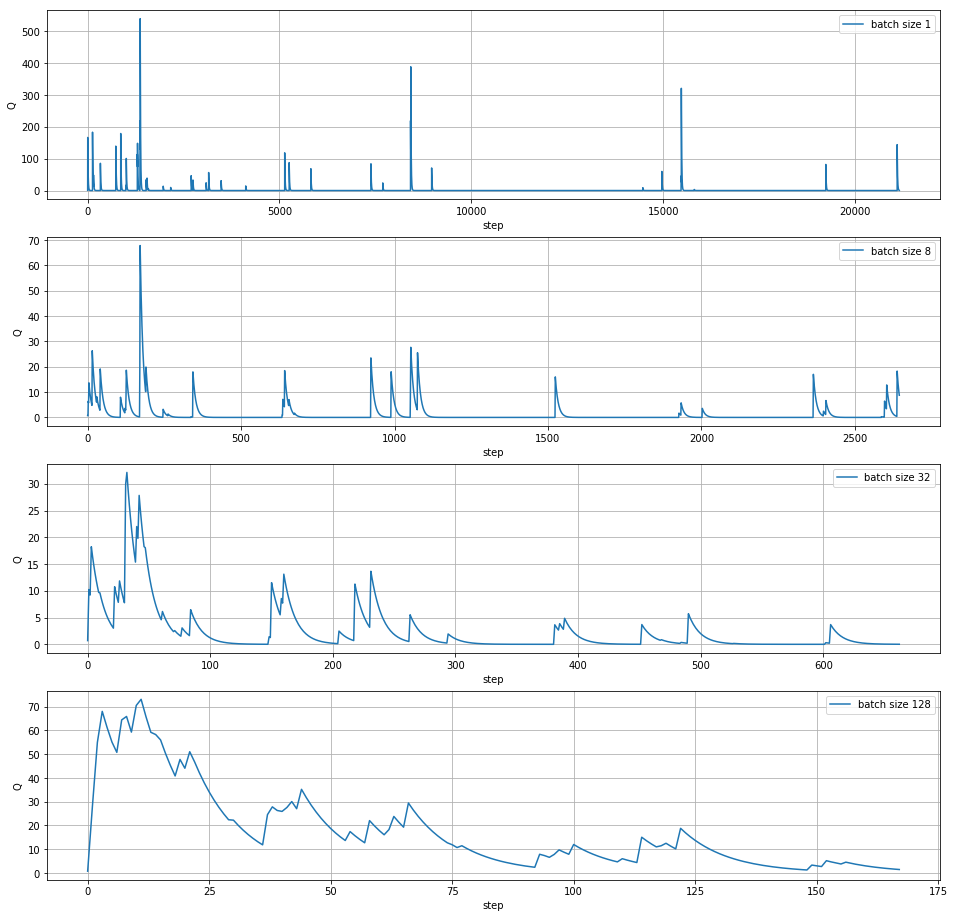

In [39]:
_, width = X_train.shape

plt.figure(figsize=(16, 16))
for i, batch_size in enumerate([1, 8, 32, 128], 1):
    w, loss = stohastic_gradient_descent(
        Q,
        Qgrad,
        X_train,
        y_train,
        np.zeros((width, 1)),
        batch_size = batch_size
    )
    
    plt.subplot(4, 1, i)
    
    plt.xlabel('step')
    plt.ylabel('Q')
    
    plt.plot(smooth(loss), label='batch size {size}'.format(size=batch_size))

    plt.grid()
    plt.legend()
    

Определим функцию accuracy.

In [40]:
def accuracy(y_true, y_pred):
    return (y_true == y_pred).sum() / len(y_true)

Теперь посмотрим качество на тестовой выборке.

In [41]:
w, _ = stohastic_gradient_descent(
    Q,
    Qgrad,
    X_train,
    y_train,
    np.zeros((width, 1)),
)

y_pred = X_test @ w

y_pred[y_pred >= 0] = +1
y_pred[y_pred < 0] = -1

print('accuracy = {acc}'.format(acc=accuracy(y_test, y_pred)))

time 0.2705061435699463 s.
accuracy = 0.9977324263038548


Можно видеть, что даже такая простая модель, как линейный классификатор может легко отличать две рукописные цифры друг от друга. 

Далее мы рассмотрим кое-какие модификации градиентного спуска на парочке простых фукнций.

In [42]:
@timeit
def impulse_gradient_descent(func_grad, x_init, step=1e-3, impulse_coef=0.85, grad_min_val=1e-6):
    x = x_init
    path = []
    impulse = 0.0
    
    while True:
        path.append(x.copy())    
        grad = func_grad(x)
            
        if np.linalg.norm(grad) < grad_min_val:
            return x, np.array(path)
        
        impulse = impulse_coef*impulse + step * grad
        x -= impulse

Нам снова надо определить саму функцию и ее градиент.

In [43]:
def Q(x, y):
    return 10 * x**2 + y**2

def Qgrad(x, y):
    return 20*x, 2*y

А теперь сравним треки.

time 0.1182558536529541 s.
time 0.029813051223754883 s.


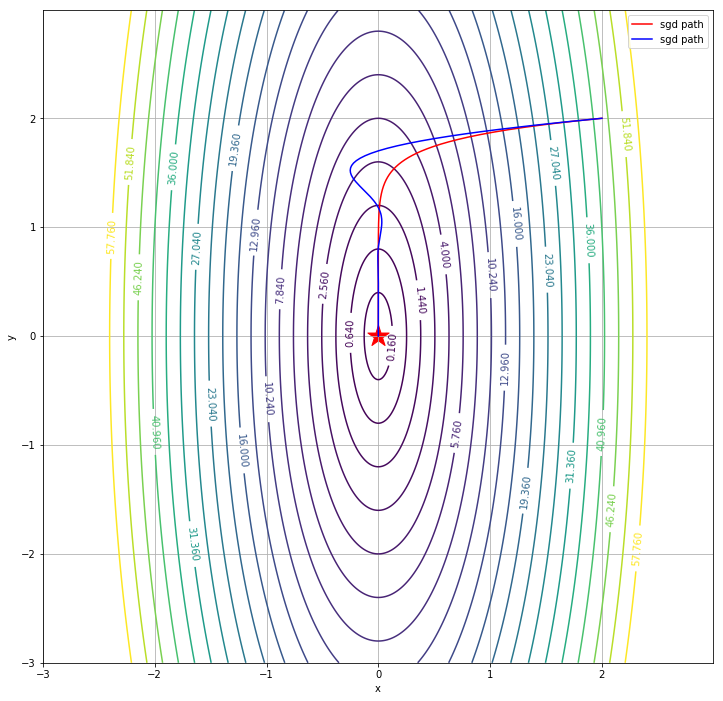

In [44]:
plt.figure(figsize=(12, 12))
plt.xlabel('x')
plt.ylabel('y')

x_grid, y_grid = np.meshgrid(
    np.arange(-3.0, 3.0, 0.01),
    np.arange(-3.0, 3.0, 0.01)
)

z_grid = Q(x_grid, y_grid)

levels = np.arange(0.0, 8.0, 0.4)**2
contour = plt.contour(x_grid, y_grid, z_grid, levels)
plt.clabel(contour, inline=True, fontsize=10)


x_min, path_gradient = gradient_descent(vectorize(Qgrad), np.array([2.0, 2.0]), step=1e-3)
plt.plot(
    path_gradient[:, 0],
    path_gradient[:, 1],
    color = 'red',
    label='sgd path'
)

_, path_impulse_gradient = impulse_gradient_descent(vectorize(Qgrad), np.array([2.0, 2.0]), step=1e-3)
plt.plot(
    path_impulse_gradient[:, 0],
    path_impulse_gradient[:, 1],
    color = 'blue',
    label='sgd path'
)

plt.scatter(
    x_min[0],
    x_min[1],
    s = 500,
    color = 'red',
    marker = '*'    
)

plt.grid()
plt.legend();

Посмотрим, как быстро методы сходятся.

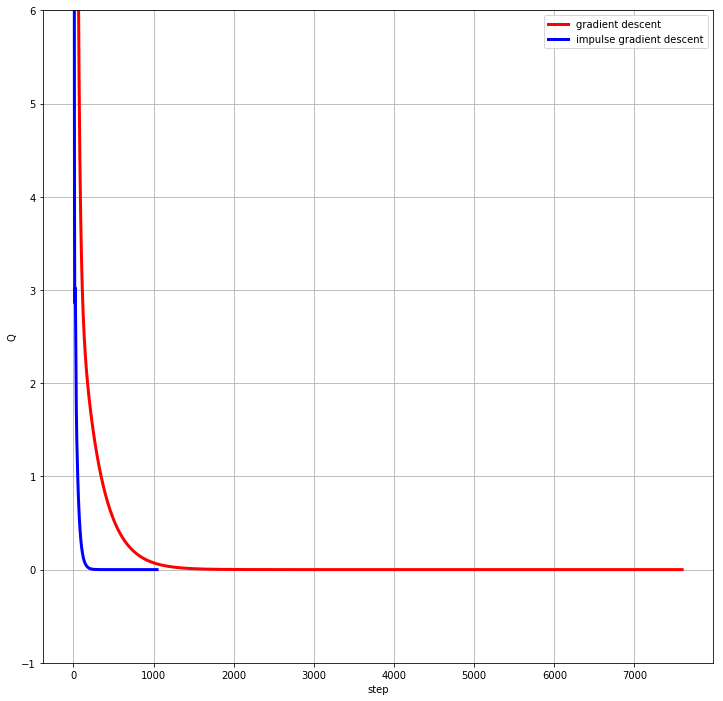

In [45]:
plt.figure(figsize=(12, 12))
plt.xlabel('step')
plt.ylabel('Q')

plt.ylim(-1.0, 6.0)

plt.plot(
    [vectorize(Q)(x) for x in path_gradient],
    label ='gradient descent',
    color = 'red',
    linewidth=3
)
plt.plot(
    [vectorize(Q)(x) for x in path_impulse_gradient],
    label='impulse gradient descent',
    color = 'blue',
    linewidth=3
)

plt.grid()
plt.legend();

Ну а теперь простестируем ускоренный градиент Нестерова на функции Розенброка.

In [46]:
@timeit
def nesterov_gradient_descent(func_grad, x_init, step=1e-3, impulse_coef=0.85, grad_min_val=1e-6):
    x = x_init
    path = []
    impulse = 0.0
    
    while True:
        path.append(x.copy())    
        grad = func_grad(x + impulse_coef*impulse)
            
        if np.linalg.norm(grad) < grad_min_val:
            return x, np.array(path)
        
        impulse = impulse_coef*impulse + step * grad
        x -= impulse

Отобразим треки.

time 1.772434949874878 s.
time 1.264530897140503 s.


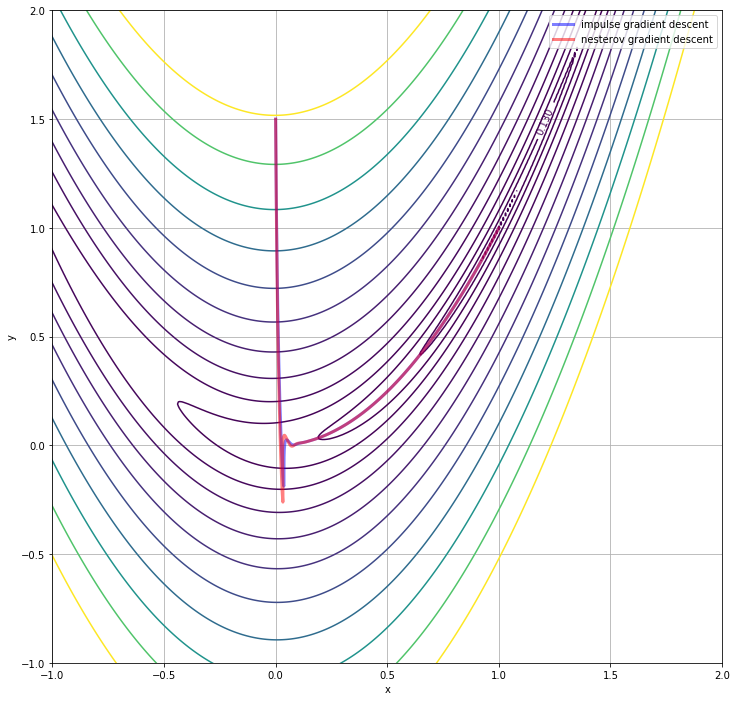

In [47]:
plt.figure(figsize=(12, 12))
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-1, 2)
plt.ylim(-1, 2)

x_grid, y_grid = np.meshgrid(
    np.arange(-3.0, 3.0, 0.01),
    np.arange(-3.0, 3.0, 0.01)
)

z_grid = R(x_grid, y_grid)

levels = np.arange(0, 4, 0.3)**4
contour = plt.contour(x_grid, y_grid, z_grid, levels)
plt.clabel(contour, inline=True, fontsize=10)

_, path_impulse_gradient = impulse_gradient_descent(vectorize(Rgrad), np.array([0.0, 1.5]), step=1e-4)
plt.plot(
    path_impulse_gradient[:, 0],
    path_impulse_gradient[:, 1],
    color = 'blue',
    alpha = 0.5,
    label='impulse gradient descent',
    linewidth=3
)

_, path_nesterov_gradient = nesterov_gradient_descent(vectorize(Rgrad), np.array([0.0, 1.5]), step=1e-4)
plt.plot(
    path_nesterov_gradient[:, 0],
    path_nesterov_gradient[:, 1],
    color = 'red',
    alpha = 0.5,
    label='nesterov gradient descent',
    linewidth=3
)

plt.grid()
plt.legend();

Оба алгоритма ведут себя достаточно похоже, со сходимостью дела обстоят также.

Теперь перейдем к задаче mnist, когда нужно предсказать все 10 цифр. Это хороший пример многоклассовый классификации. Для этого нам потребуется [softmax](https://en.wikipedia.org/wiki/Softmax_function). А в качестве функции потерь будем использовать [log loss](https://en.wikipedia.org/wiki/Cross_entropy). В итоге мы будем оптимизировать следующий функционал

$$\arg\min_W -\frac{1}{\mathcal{l}}\sum_{x, y}\sum_j [y = j] \cdot \ln(p_j(W)),$$

где $w_i$ это $i$-я строка в матрице $W$.

$$\arg\min_W -\frac{1}{\mathcal{l}}\sum_{x, y}\sum_j [y = j] \cdot \ln \Big(\frac{\exp(w_jx)}{\sum_i \exp(w_ix)}\Big),$$


$$\arg\min_W -\frac{1}{\mathcal{l}}\sum_{x, y}\sum_j [y = j] \cdot \Big(w_jx - \log \sum_i \exp(w_ix)\Big),$$

Производную удобнее найти для одной пары признаков и метки. Пусть у нас класс $y$, тогда распишем частные производные. Если $j = y$, то
$$\frac{\partial L}{\partial w_j} = \Big(\frac{\exp(w_jx)x}{\sum_i \exp(w_ix)} - 1\Big) \cdot x,$$
в то время, как для $w_j, j \neq y$

$$\frac{\partial L}{\partial w_j} = \frac{\exp(w_jx)}{\sum_i \exp(w_ix)} \cdot x,$$

Теперь все это надо запрограммировать. Сначала определим softmax.

In [48]:
def softmax(x):
    values = np.exp(x - x.max())
    return values / values.sum()

После чего опишем функцию потерь и его производную.

In [49]:
def Q(X, y, W):
    values = X @ W.T
    
    result = 0.0
    for label, value in zip(y, values):
        prob = softmax(value)[label]
        if prob == 0:
            return +np.inf
        result -= np.log(prob)
        
    return result / len(y)

def Qgrad(X, y, W):
    result = np.zeros(W.shape)
    values = X @ W.T
    
    for x, label, value in zip(X, y, values):
        sm = softmax(value)
        for i, w in enumerate(result):
            w += sm[i] * x
            if i == label:
                w -= x
                
    return result / len(y)

Нам нужно заново подготовить данные.

In [50]:
X, y = data[:, 1:], data[:, 0:1].astype(np.int64)

border = int(len(y) * 0.8)

X_train, X_test = X[:border, :], X[border:, :]
y_train, y_test = y[:border], y[border:]

И испытать модель.

In [51]:
_, width = X_train.shape

W, _ = stohastic_gradient_descent(
    Q,
    Qgrad,
    X_train,
    y_train,
    np.random.uniform(-1, 1, (10, width)),
    batch_size = 64,
    step = 1e-2,
    epoch_n = 20
)

time 124.89705491065979 s.


Проверим качество нашей модели

In [52]:
y_pred = np.argmax(X_test @ W.T, 1).reshape(y_test.shape)
print('accuracy = {acc}'.format(acc=accuracy(y_test, y_pred)))

accuracy = 0.8945238095238095


Отрисуем то, как выглядят полученые векторы весов для каждого класса, это будет интересно!

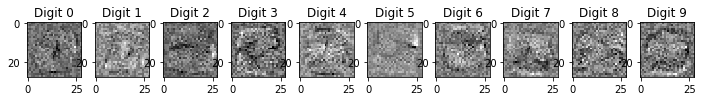

In [53]:
plt.figure(figsize=(12, 1))
for i in range(0, 10):
    plt.subplot(1, 10, i + 1)    
    plt.title('Digit {}'.format(i))
    plt.imshow(W[i,:].reshape(img_height, img_width), cmap="gray")

Для дальнейшего наращивания качества можно попробовать добавить регуляризацию, испытать другие оптимизаторы и т.п. А теперь посмотрим, как выглядит уравнения прямы для многоклассовой классификации на более простом примере.

In [62]:
mu_green = np.array([3, -2])
V_green = np.array([[1., 0.],[-1., 1.]])

X_green = np.random.multivariate_normal(mu_green, V_green, POINT_N)

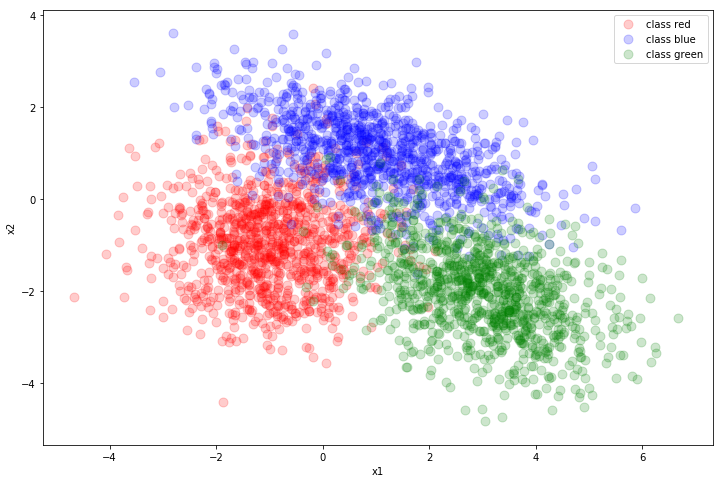

In [68]:
plt.figure(figsize=(12, 8))
plt.xlabel('x1')
plt.ylabel('x2')

colors = ['red', 'blue', 'green']
Xs = [X_red, X_blue, X_green]

for color, X in zip(colors, Xs):
    plt.scatter(
        x = X[:, 0],
        y = X[:, 1],
        label = f'class {color}' ,
        color = f'{color}',
        s = 80,
        alpha = 0.2
    )

plt.legend();

In [64]:
X = np.vstack([X_red, X_blue, X_green])
X = np.hstack([X, np.ones((3 * POINT_N, 1))])

y = np.vstack([np.full((POINT_N, 1), i) for i in range(3)])

In [65]:
W, _ = stohastic_gradient_descent(
    Q,
    Qgrad,
    X,
    y,
    np.random.uniform(-1, 1, (3, 3)),
    batch_size = 32,
    step = 1e-2,
    epoch_n = 20
)

time 5.316835641860962 s.


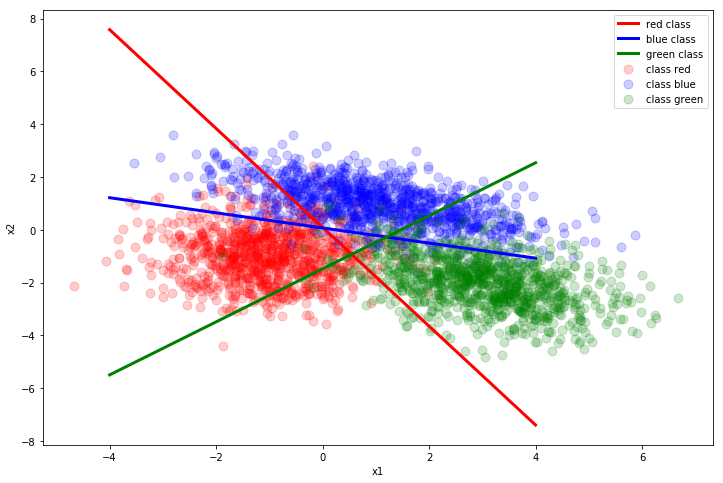

In [71]:
plt.figure(figsize=(12, 8))
plt.xlabel('x1')
plt.ylabel('x2')

line_x1 = np.array([-4., 4.])

for i, (color, X) in enumerate(zip(colors, Xs)):
    plt.scatter(
        x = X[:, 0],
        y = X[:, 1],
        label = f'class {color}' ,
        color = f'{color}',
        s = 80,
        alpha = 0.2
    )
    
    plt.plot(
        line_x1,
        line_x2(W[i,:], line_x1),
        label = f'{color} class',
        color = f'{color}',
        linewidth = 3
    )

plt.legend();